# Predicting Used Car Prices with Linear Regression
## Introduction


---
### Dataset Description
The dataset contains information about used cars, including features such as:

**Year:** The manufacturing year of the car.

**Kilometers_Driven:** Total distance driven (in kilometers).

**Fuel_Type:** Type of fuel (e.g., Petrol, Diesel, CNG, LPG).

**Transmission:** Manual or Automatic.

**Owner_Type:** Ownership history (e.g., First, Second).

**Mileage:** Fuel efficiency (e.g., kmpl or km/kg).

**Engine:** Engine displacement (in CC).

**Power:** Engine power (in bhp).

**Seats:** Number of seats.

**Price:** Target variable (price in lakhs).

**New_Price:** Price of the brand new car of the same characteristics.

## Step 1: Import Libraries
Let's start by importing the necessary Python libraries for data manipulation, modeling, and visualization.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump

## Step 2: Load and Preview Dataset
We'll load the dataset and perform an initial exploration to understand its structure and contents.

In [50]:
# Load the dataset
df = pd.read_csv('used_cars_data.csv')

# Display the first few rows
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### Observations

- The dataset includes both numerical (e.g., Year, Kilometers_Driven) and categorical (e.g., Fuel_Type, Transmission) features.
- Some columns like 'Mileage', 'Engine', and 'Power' contain units (e.g., kmpl, CC, bhp) that need cleaning.
- 'New_Price' has missing values in many rows, and 'S.No.' is an index column that can be dropped.

Let's check for missing values and data types.

In [51]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check data types
print("\nData Types:\n", df.dtypes)

Missing Values:
 S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
dtype: int64

Data Types:
 S.No.                  int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object


## Step 3: Data Processing
To prepare the data for modeling, we'll clean it, handle missing values, and encode categorical variables.

### 3.1 Drop Unnecessary Columns
- **S.No.:** An index column, not useful for prediction.
- **New_Price:** Too many missing values, so we'll exclude it.
- **Name:** Too specific; we'll extract the brand instead.

In [52]:
# Drop unnecessary columns
df = df.drop(['S.No.', 'New_Price'], axis=1)

# Extract brand from Name and drop Name
df['Brand'] = df['Name'].apply(lambda x: x.split()[0])
df = df.drop('Name', axis=1)

### 3.2 Clean Numerical Columns
Columns like 'Mileage', 'Engine', and 'Power' contain strings with units. We'll extract the numerical values.

In [53]:
def extract_number(s):
    if pd.isnull(s) or 'null' in str(s):
        return np.nan
    try:
        return float(s.split()[0])
    except:
        return np.nan

# Apply to relevant columns
df['Mileage'] = df['Mileage'].apply(extract_number)
df['Engine'] = df['Engine'].apply(extract_number)
df['Power'] = df['Power'].apply(extract_number)
df['Seats'] = pd.to_numeric(df['Seats'], errors='coerce')

### 3.3 Handle Missing Values
We'll impute missing values in numerical columns with the median to reduce the impact of outliers.

In [54]:
# Calculate medians for columns with missing values
fill_dict = {col: df[col].median() for col in ['Mileage', 'Engine', 'Power', 'Seats']}

# Fill missing values in place using the dictionary
df.fillna(fill_dict, inplace=True)

# Remove rows where 'Price' is missing
df = df.dropna(subset=['Price'])

# Verify no missing values remain in the specified columns
print("Missing Values after filling:\n", df[['Mileage', 'Engine', 'Power', 'Seats']].isnull().sum())

# Verify no missing values in target
print("Missing Values in Price:", df['Price'].isnull().sum())

Missing Values after filling:
 Mileage    0
Engine     0
Power      0
Seats      0
dtype: int64
Missing Values in Price: 0


### 3.4 Encode Categorical Variables
Categorical columns ('Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Brand') need to be converted to numerical format using one-hot encoding.

In [55]:
# Check unique values to assess encoding feasibility
print("Unique Locations:", df['Location'].nunique())
print("Unique Brands:", df['Brand'].nunique())

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Brand'], drop_first=True)

Unique Locations: 11
Unique Brands: 31


## 4: Exploratory Data Analysis (EDA)
Before modeling, let's visualize the data to understand relationships and distributions.

### 4.1 Correlation Heatmap
We'll examine correlations among numerical features and the target variable.

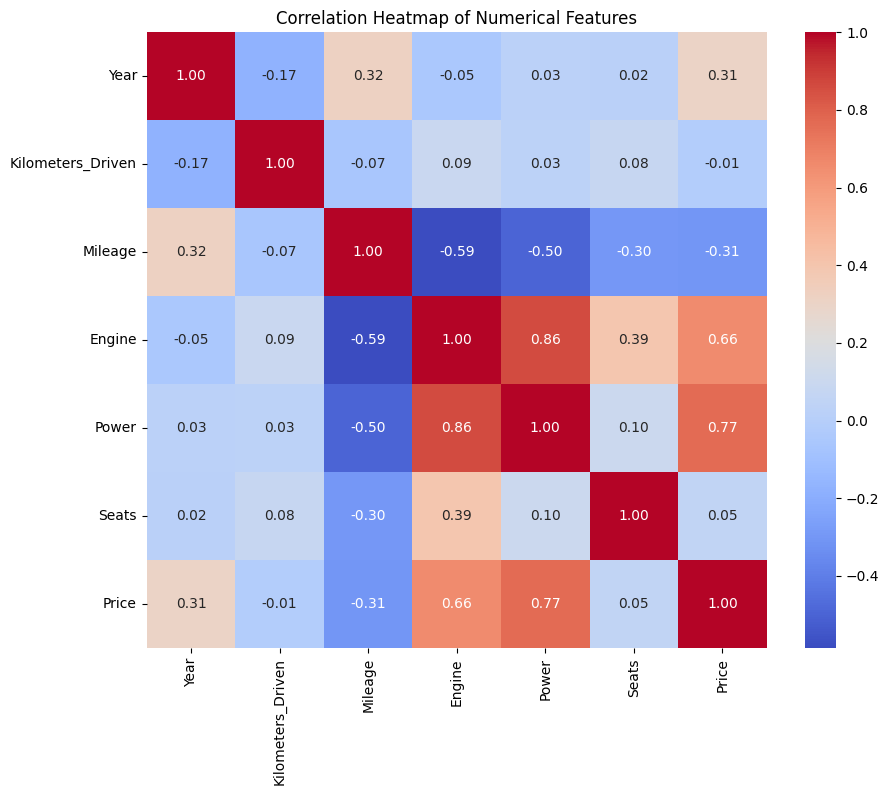

In [56]:
numerical_cols = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

#### Insights:

- 'Year' and 'Power' positively correlate with 'Price' (newer, more powerful cars are pricier).
- 'Kilometers_Driven' negatively correlate (higher mileage reduces price).

### 4.2 Price Distribution
Let's check the distribution of our target variable.

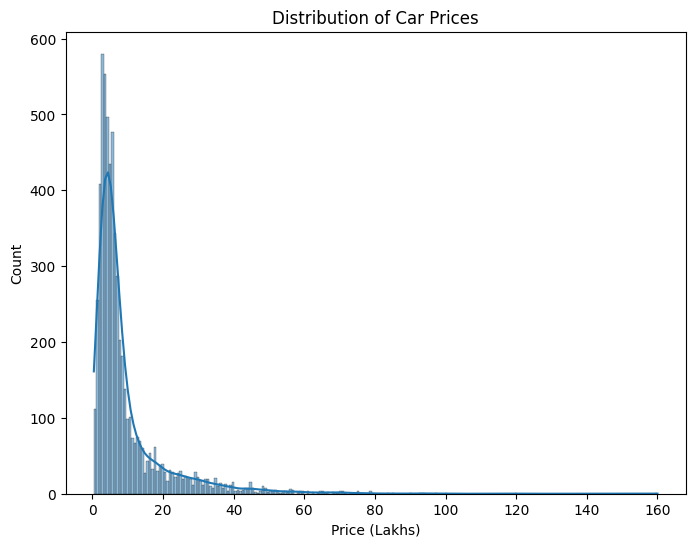

In [57]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (Lakhs)')
plt.show()

### 4.3 Scatter Plots
Visualize key features vs. price.

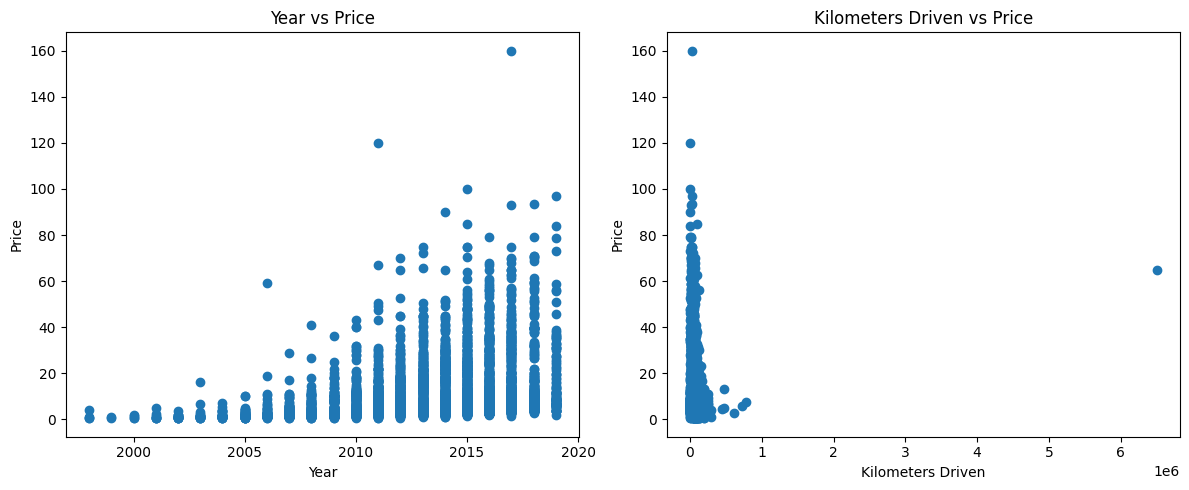

In [58]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df['Year'], df['Price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Year vs Price')

plt.subplot(1, 2, 2)
plt.scatter(df['Kilometers_Driven'], df['Price'])
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.title('Kilometers Driven vs Price')
plt.tight_layout()
plt.show()

**Insigts**: These plots confirm expected trends and help identify outliers.